# Data exploration "Traffic Sign Detection Database", by the National Nature Science Foundation of China(NSFC)

This file covers the exploration of the "Traffic Sign Detection Database" by the National Nature Science Foundation of China(NSFC. The TSDD includes 10000 traffic scene images containing many kinds of signs. The images are collected under different time,weather condition,lighting condition as well as moving blurring.

For the sake of comparing this dataset to the "Signs of Surveillance" (SoS) dataset, only 2000 images will be used. Reason being, that this amount is the same as amount of images in the SoS dataset.

Since this dataset is already fully annotated, this dataset will not be cleaned that much, but anomalies will be researched and the same procedures will be used as on the SoS dataset.

In [1]:
# Imports
from PIL import Image
from tqdm import tqdm
import pathlib
import os, os.path
import pandas as pd
import matplotlib.pylab as plt
import random
from pathlib import Path
import pytesseract
import seaborn as sns
import re
import glob
import matplotlib.patches as patches
from cv2 import cv2
import numpy as np
import shutil
from collections import Counter

In [2]:
# Assign path, change to you path where the TSDD images are stored
folder_images = r"F:\Thesis\Signs_explore\TsignDet_Test_Database\test_image"

# Assign path of annotation location
boxes = r'F:\Thesis\Signs_explore\TsignDet_Test_Database_Annotation\lable'

# Assign path where the cleaned dataset should be saved
new_folder_path = r'F:\Thesis\Signs_explore\cleaning\cleaned_traffic'

# File extension inspection

<BarContainer object of 3 artists>

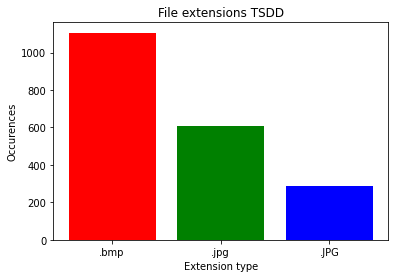

In [3]:
# Plotting all the different file extensions
suffixes = [Path(x).suffix for x in os.listdir(folder_images)]
suffixes = Counter(suffixes)
plt.title("File extensions TSDD")
plt.xlabel("Extension type")
plt.ylabel("Occurences")
plt.bar(suffixes.keys(), suffixes.values(), color=['red', 'green', 'blue'])

In [4]:
# Function to collect images and convert images to the same file extension
def load_images_from_folder(folder):
    images = []
    imagenames = []
    for filename in os.listdir(folder):
        cleanname = Path(filename)
        cleanname = cleanname.with_suffix('')
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
            imagenames.append(filename)
            im = Image.open(r"F:\Thesis\Signs_explore\TsignDet_Test_Database\test_image\{}".format(filename))
            im.save(r'F:\Thesis\Signs_explore\cleaning\cleaned_traffic\{}.jpg'.format(cleanname))
    return zip(imagenames, images)

In [7]:
collection = load_images_from_folder(folder_images)

# Heigth, width and aspect ratio inspection

In [8]:
# Create dictionary in with the width and heigth of each image
size_images = dict()
for img in collection:
    heigth, width, channels = img[1].shape
    size_images[img[0]] = {'width': width, 'heigth': heigth, 'channels':channels}

In [9]:
# Turn to Pandas dataframe
df = pd.DataFrame.from_dict(size_images , orient='index')
df = df.reset_index().rename(columns={"index": "file_Name"})
df

,file_Name,width,heigth,channels
0,css (1).bmp,640,480,3
1,css (10).bmp,640,480,3
2,css (100).bmp,640,480,3
3,css (101).bmp,640,480,3
4,css (102).bmp,640,480,3
...,...,...,...,...
1995,zjp (5).jpg,640,426,3
1996,zjp (6).jpg,640,426,3
1997,zjp (7).jpg,640,426,3
1998,zjp (8).jpg,640,426,3


In [10]:
df['width'].value_counts()

640     1495
2560     284
4128       4
766        3
800        3
        ... 
817        1
943        1
889        1
821        1
5184       1
Name: width, Length: 181, dtype: int64

c:\users\kishan\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


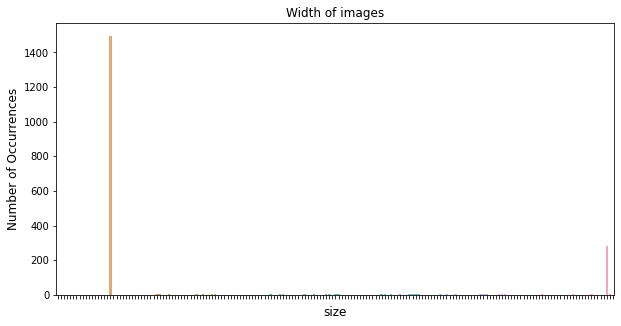

In [11]:
width = df['width'].value_counts()
plt.figure(figsize=(10,5))
x = sns.barplot(width.index, width.values, alpha=0.8)
x.set(xticklabels=[])
plt.title('Width of images')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('size', fontsize=12)
plt.show()

In [12]:
df['heigth'].value_counts()

480     1041
426      436
1920     284
479        6
427        5
        ... 
484        1
526        1
570        1
580        1
3456       1
Name: heigth, Length: 152, dtype: int64

c:\users\kishan\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


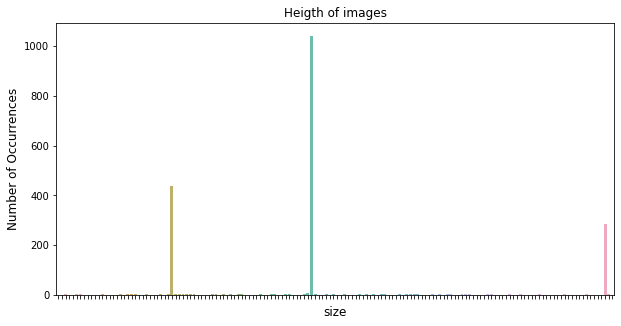

In [13]:
heigth = df['heigth'].value_counts()
plt.figure(figsize=(10,5))
x = sns.barplot(heigth.index, heigth.values, alpha=0.8)
x.set(xticklabels=[])
plt.title('Heigth of images')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('size', fontsize=12)
plt.show()

c:\users\kishan\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


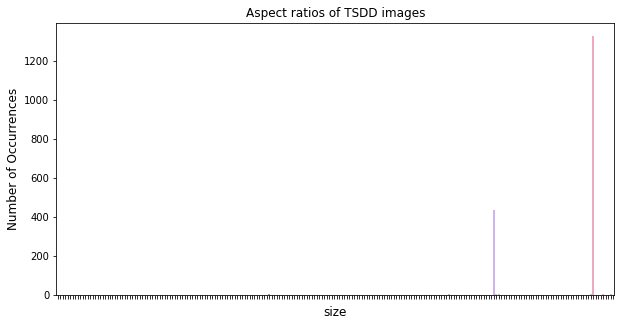

In [14]:
df['aspect'] = df['heigth'] / df['width']
aspect = df['aspect'].value_counts()
plt.figure(figsize=(10,5))
x = sns.barplot(aspect.index, aspect.values, alpha=0.8)
x.set(xticklabels=[])
plt.title('Aspect ratios of TSDD images')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('size', fontsize=12)
plt.show()

In [15]:
aspect

0.750000    1328
0.665625     434
0.748437       6
0.667188       5
0.785937       3
            ... 
0.709914       1
0.547190       1
0.591286       1
0.529809       1
0.675039       1
Name: aspect, Length: 224, dtype: int64

# Annotation inspection

In [16]:
# Function to see the bounding boxes of an image
def SeeBoxes(image):
    im = Image.open('F:\Thesis\Signs_explore\cleaning\cleaned_traffic\{}.jpg'.format(image))
    fig, ax = plt.subplots()
    ints = []
    intbox = []
    
    
    with open('F:\Thesis\Signs_explore\TsignDet_Test_Database_Annotation\lable\{}.txt'.format(image)) as file:
        lines = [line.rstrip() for line in file if len(line) > 2]
    
    for box in lines:
        for x in box.split(','):
            ints.append(int(x))
        
        rect = patches.Rectangle(ints, 40, 30, linewidth=1, edgecolor='r', facecolor='none')
        ints = []
        # Add the patch to the Axes
        ax.add_patch(rect)
        
    # Display the image
    ax.imshow(im)
    plt.show()

In [17]:
# Function to inspect a random sample of images 
def image_gallery_depricated(path, images):
    image_list = []
    for filename in glob.glob(path + '/*.jpg'): #assuming gif
        im=Image.open(filename)
        image_list.append(im)
        
    image_list = random.sample(image_list, images)
    plt.figure(figsize=(75,75))
    columns = 3
    for i, image in enumerate(image_list):
        print(os.path.basename(image.filename))
        plt.subplot(len(image_list) / columns + 1, columns, i + 1)
        plt.imshow(image)

In [ ]:
# Function to inspect a random sample of images including bounding boxes
def image_gallery(path, images):
    # Function to inspect a random sample of images
    image_list = []
    for filename in glob.glob(path + '/*.jpg'): #assuming gif
        im=Image.open(filename)
        image_list.append(im)
        
    image_list = random.sample(image_list, images)
    for i, image in enumerate(image_list):
        cleanname = Path(os.path.basename(image.filename))
        cleanname = cleanname.with_suffix('')
        print(cleanname)
        im = Image.open('F:\Thesis\Signs_explore\cleaning\cleaned_traffic\{}.jpg'.format(cleanname))
        fig, ax = plt.subplots()
        ints = []
        intbox = []
        
        with open('F:\Thesis\Signs_explore\TsignDet_Test_Database_Annotation\lable\{}.txt'.format(cleanname)) as file:
            lines = [line.rstrip() for line in file if len(line) > 2]
        
        for box in lines:
            for x in box.split(','):
                ints.append(int(x))
        
            rect = patches.Rectangle(ints, 40, 30, linewidth=1, edgecolor='r', facecolor='none')
            ints = []
            # Add the patch to the Axes
            ax.add_patch(rect)
        
        # Display the image
        ax.imshow(im)
        plt.show()

lsd (1)


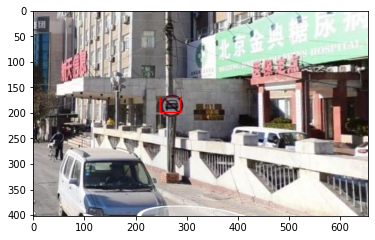

test (120)


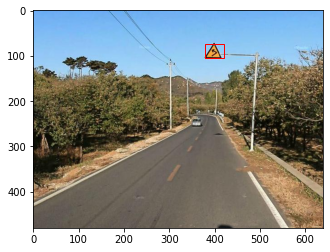

test (130)


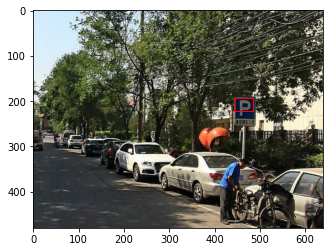

gzs (1021)


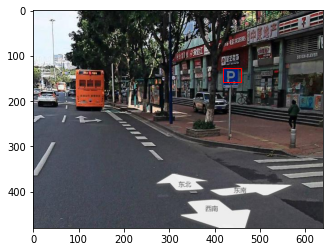

In [21]:
image_gallery(new_folder_path, 4)